*   Analyzing the domain of sales and understanding customer behavior.
*   Performing the Exploratory Data Analysis based on the insights gained from domain knowledge.
*   Pre-Processing of the data to remove the outliers, imputing the data for missing values.
*   Scaling the data to normalize the values.
*   Considering the important features by reducing the dimensionality using PCA.
*   Using the Clustering technique to identify the segments of customers.
*   Quantum Enhancements (Comparing Algorithm on Classical vs Quantum) 

In [7]:
# Import the pandas library. More information: https://pandas.pydata.org/
import pandas as pd
import numpy as np
# Importing the marketing campaign dataset
# Import the data as a pandas dataframe
cpa = pd.read_csv("/content/marketing_campaign.csv", sep="\t")

cpa.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Now let's learn more about the data and attributes of the given dataset. Given dataset can be divided into 4 parts:

Customer Information

Product Information

Promotion Information

Place Information

Dividing the attributes into their respective parts:

**Customer Information:**

-> ID : Customer's unique identification number

-> Year_Birth : Customer's birth year

-> Education : Customer's education status

-> Marital_Status : Customer's Marital status

-> Income : Customer's Income

-> Kidhome : Number of children in Customer's household

-> Teenhome : Number of teenagers in Customer's household

-> Dt_Customer : Customer's enrollment date with the company

-> Recency : Number of days since Customer's last purchase

-> Complain : 0 if Customer didn't complain in last 2 years, else 1

**Product Information:**

-> MntWines: Amount spent on wine in last 2 years

-> MntFruits: Amount spent on fruits in last 2 years

-> MntMeatProducts: Amount spent on meat products in last 2 years

-> MntFishProducts: Amount spent on fish products in last 2 years

-> MntSweetProducts: Amount spent on sweet products in last 2 years

-> MntGoldProds: Amount spent on gold products in last 2 years

**Promotion Information:**

-> NumDealsPurchases: Number of purchases made with a discount

-> AcceptedCmp1: 0 if Customer declined the offer in 1st campaign, else 1

-> AcceptedCmp2: 0 if Customer declined the offer in 2nd campaign, else 1

-> AcceptedCmp3: 0 if Customer declined the offer in 3rd campaign, else 1

-> AcceptedCmp4: 0 if Customer declined the offer in 4th campaign, else 1

-> AcceptedCmp5: 0 if Customer declined the offer in 5th campaign, else 1

-> Response: 0 if Customer declined the offer in the last campaign, else 1

**Place Information:**

-> NumWebPurchases: Number of purchases made through the company’s website

-> NumCatalogPurchases: Number of purchases made using a catalog

-> NumStorePurchases: Number of purchases made directly in store

-> NumWebVisitsMonth: Number of visits to company’s website in the last month

There are a total of 29 attributes and 2240 values

In [8]:
#overview of the attributes in the dataset
cpa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Only Income field has null values.

In [9]:
cpa['ID'].describe() #min value is zero, so all the data is positive. 

count     2240.000000
mean      5592.159821
std       3246.662198
min          0.000000
25%       2828.250000
50%       5458.500000
75%       8427.750000
max      11191.000000
Name: ID, dtype: float64

In [10]:
#replacing the income with mode.
mode = cpa['Income'].mode()[0]
cpa['Income'] = cpa['Income'].fillna(mode)
cpa['Income'].isna().sum() #checking the values

0

We will come across outliers, and we will remove them if they are less in number.

Now we are going to combine few columns into a single column

First getting into the family details :

-> Combine kidhome and teenhome to get the total number of children in the customer's household

-> Get the total headcount of the family

In [11]:
cpa['Kids'] = cpa['Kidhome'] + cpa['Teenhome']

#Deriving living situation by marital status Solo or Couple
cpa["Living_With"]=cpa["Marital_Status"].replace({"Married": 2, "Together": 2, "Absurd": 1, "Alone":1, "Widow": 1, "YOLO": 1, "Divorced": 1, "Single": 1,})

#Feature for total members in the householde
cpa["Family_headcount"] = cpa["Living_With"] + cpa['Kids']

#creating a feature pertaining parenthood
cpa["Is_Parent"] = np.where(cpa.Kids> 0, 1, 0)



**Lets** get the latest and oldest dates of customer's enrollement to get the span of this dataset

In [12]:
cpa['Dt_Customer'] = pd.to_datetime(cpa['Dt_Customer'])

cpa['Dt_Customer'].max(), cpa['Dt_Customer'].min()

(Timestamp('2014-12-06 00:00:00'), Timestamp('2012-01-08 00:00:00'))

The span is nearly 2 years.

Now lets go a little back in time so that we can get the details to be readable and makes much more sense.

We will assume that the customer information was collected 2014-12-07.

In [13]:
#calculating age based on Year of Birth
cpa['Age'] = 2014 - cpa['Year_Birth']

#Year_Birth is no longer required. So, dropping the column
cpa=cpa.drop(columns="Year_Birth")

#check the values in the new column
cpa['Age'].value_counts()

# data has outliers with age>100. setting the boundary as 100 replacing all values 100 where age is greater than 100
cpa['Age'].apply(lambda x: 100 if (x > 100) else x)


0       57
1       60
2       49
3       30
4       33
        ..
2235    47
2236    68
2237    33
2238    58
2239    60
Name: Age, Length: 2240, dtype: int64

In [14]:
cpa['Collected'] = '2014-12-07'
cpa['Collected'] = pd.to_datetime(cpa['Collected'])

cpa['Days_is_client'] = (cpa['Collected'] - cpa['Dt_Customer']).dt.days

Now going through the product and place details:

-> Get the total spending amount

-> Get the total number of purchases

-> Get Average Amount spent

-> Get the total share deals from the total number of purchases

-> Get the total number of accepted offers in all campaigns



In [15]:
cpa['MntTotal'] = cpa['MntWines']+cpa['MntFruits']+cpa['MntMeatProducts']+cpa['MntFishProducts']+cpa['MntSweetProducts']+cpa['MntGoldProds']

cpa['NumAllPurchases'] = cpa['NumWebPurchases']+cpa['NumCatalogPurchases']+cpa['NumStorePurchases']

cpa['AverageCheck'] = round((cpa['MntTotal'] / cpa['NumAllPurchases']), 1)

cpa['ShareDealsPurchases'] = round((cpa['NumDealsPurchases'] / cpa['NumAllPurchases']) * 100, 1)

cpa['TotalAcceptedCmp'] = cpa['AcceptedCmp1']+cpa['AcceptedCmp2']+cpa['AcceptedCmp3']+cpa['AcceptedCmp4']+cpa['AcceptedCmp5']+cpa['Response']

On checking the data we get to see that 6 customers have spent money but didn't make any purchase which makes no sense.

We are going to delete those six customers

Now our datacount will 2210

In [16]:
cpa = cpa.query("NumAllPurchases != 0")

Let's cover the outliers now

In [17]:
cpa['Income'] = np.where(cpa['Income'] > 120000, 120000, cpa['Income'])

cpa['AverageCheck'] = np.where(cpa['AverageCheck'] > 200, 200, cpa['AverageCheck'])

In [18]:
#Grouping education levels in to three categories
cpa["Education"]=cpa["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})


In [19]:
#Deriving living situation by marital status Solo or Couple
cpa["Living_With"]=cpa["Marital_Status"].replace({"Married": 2, "Together": 2, "Absurd": 1, "Alone":1, "Widow": 1, "YOLO": 1, "Divorced": 1, "Single": 1,})

#Marital status is no longer required. So, dropping the column
cpa=cpa.drop(columns="Marital_Status")


In [ ]:
cpa

,ID,Education,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Family_headcount,Is_Parent,Age,Collected,Days_is_client,MntTotal,NumAllPurchases,AverageCheck,ShareDealsPurchases,TotalAcceptedCmp
0,5524,Graduate,58138.0,0,0,2012-04-09,58,635,88,546,...,1,0,57,2014-12-07,972,1617,22,73.5,13.6,1
1,2174,Graduate,46344.0,1,1,2014-08-03,38,11,1,6,...,3,1,60,2014-12-07,126,27,4,6.8,50.0,0
2,4141,Graduate,71613.0,0,0,2013-08-21,26,426,49,127,...,2,0,49,2014-12-07,473,776,20,38.8,5.0,0
3,6182,Graduate,26646.0,1,0,2014-10-02,26,11,4,20,...,3,1,30,2014-12-07,66,53,6,8.8,33.3,0
4,5324,Postgraduate,58293.0,1,0,2014-01-19,94,173,43,118,...,3,1,33,2014-12-07,322,422,14,30.1,35.7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,Graduate,61223.0,0,1,2013-06-13,46,709,43,182,...,3,1,47,2014-12-07,542,1341,16,83.8,12.5,0
2236,4001,Postgraduate,64014.0,2,1,2014-10-06,56,406,0,30,...,5,1,68,2014-12-07,62,444,15,29.6,46.7,1
2237,7270,Graduate,56981.0,0,0,2014-01-25,91,908,48,217,...,1,0,33,2014-12-07,316,1241,18,68.9,5.6,1
2238,8235,Postgraduate,69245.0,0,1,2014-01-24,8,428,30,214,...,3,1,58,2014-12-07,317,843,21,40.1,9.5,0


Let's cover the outliers now

In [20]:

#Segmenting education levels in to three groups
cpa["Education"]=cpa["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For better clarity
cpa=cpa.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Kidhome", "Teenhome", "Dt_Customer", "Z_CostContact", "Z_Revenue", "ID", "Collected"]

cpa = cpa.drop(to_drop, axis=1)

In [21]:
cpa.head()

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,...,Living_With,Family_headcount,Is_Parent,Age,Days_is_client,MntTotal,NumAllPurchases,AverageCheck,ShareDealsPurchases,TotalAcceptedCmp
0,Graduate,58138.0,58,635,88,546,172,88,88,3,...,1,1,0,57,972,1617,22,73.5,13.6,1
1,Graduate,46344.0,38,11,1,6,2,1,6,2,...,1,3,1,60,126,27,4,6.8,50.0,0
2,Graduate,71613.0,26,426,49,127,111,21,42,1,...,2,2,0,49,473,776,20,38.8,5.0,0
3,Graduate,26646.0,26,11,4,20,10,3,5,2,...,2,3,1,30,66,53,6,8.8,33.3,0
4,Postgraduate,58293.0,94,173,43,118,46,27,15,5,...,2,3,1,33,322,422,14,30.1,35.7,0


We are going to preprocess the data to make the data available for PCA

Theese are the following steps will be applied to preprocess the data:

Ensure Label encoding will take place for the categorical features

Scale all the features using the standard scaler

Creating a copy of the subset dataframe for dimensionality reduction

In [22]:
#Listing the categorical variables
cpa_categorical = (cpa.dtypes == 'object')
object_cols = list(cpa_categorical[cpa_categorical].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education']


In [23]:
#Label Encoding the object dtypes.
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
for i in object_cols:
    cpa[i]=cpa[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [24]:
cpa_copy = cpa.copy()
cat_col =  [x for x in cpa_copy.columns if ((cpa_copy[x].dtype != 'int64') & (cpa_copy[x].dtype != 'float64'))]
cpa_copy=pd.get_dummies(cpa_copy , columns=cat_col , drop_first=True)

In [25]:
from sklearn.preprocessing import StandardScaler
num_cols =  [x for x in cpa_copy.columns if ~((cpa_copy[x].dtype != 'int64') & (cpa_copy[x].dtype != 'float64'))]
Scaler = StandardScaler()
cpa_copy[num_cols] = Scaler.fit_transform(cpa_copy[num_cols])

Now we have encoded and normalized the data which is ready for dimensionality reduction.

In [26]:
to_drop=["ShareDealsPurchases","AcceptedCmp1","AcceptedCmp2","AcceptedCmp3","AcceptedCmp4","AcceptedCmp5","NumDealsPurchases","NumWebVisitsMonth","NumWebPurchases","NumCatalogPurchases","NumStorePurchases"]
cpa_copy = cpa_copy.drop(to_drop, axis=1)

In [27]:
cpa_copy

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,Complain,...,Kids,Living_With,Family_headcount,Is_Parent,Age,Days_is_client,MntTotal,NumAllPurchases,AverageCheck,TotalAcceptedCmp
0,-0.895637,0.315152,0.307582,0.981118,1.548633,1.676696,2.458536,1.473616,0.840633,-0.097413,...,-1.266783,-1.349336,-1.763961,-1.588603,0.985421,1.975431,1.676727,1.312465,1.188823,0.619279
1,-0.895637,-0.238887,-0.382905,-0.872661,-0.637518,-0.714752,-0.651775,-0.632720,-0.730909,-0.097413,...,1.395487,-1.349336,0.444945,0.629484,1.235669,-1.670576,-0.963936,-1.192963,-1.016467,-0.502756
2,-0.895637,0.948159,-0.797198,0.360221,0.568635,-0.178891,1.342483,-0.148505,-0.040964,-0.097413,...,-1.266783,0.741105,-0.659508,-1.588603,0.318093,-0.175110,0.279999,1.034084,0.041543,-0.502756
3,-0.895637,-1.164227,-0.797198,-0.872661,-0.562133,-0.652752,-0.505407,-0.584299,-0.750075,-0.097413,...,0.064352,0.741105,0.444945,0.629484,-1.266810,-1.929158,-0.920755,-0.914582,-0.950342,-0.502756
4,0.566975,0.322434,1.550459,-0.391391,0.417866,-0.218748,0.153247,-0.003240,-0.558423,-0.097413,...,0.064352,0.741105,0.444945,0.629484,-1.016562,-0.825875,-0.307922,0.198941,-0.246103,-0.502756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,-0.895637,0.460074,-0.106710,1.200957,0.417866,0.064683,0.080063,2.199939,3.887892,-0.097413,...,0.064352,0.741105,0.444945,0.629484,0.151261,0.122259,1.218348,0.477322,1.529370,-0.502756
2236,0.566975,0.591185,0.238533,0.300805,-0.662646,-0.608466,-0.688367,-0.656931,-0.692579,-0.097413,...,2.726622,0.741105,2.653852,0.629484,1.902996,-1.946397,-0.271384,0.338132,-0.262635,0.619279
2237,-0.895637,0.260801,1.446886,1.792146,0.543506,0.219684,-0.102896,-0.366402,-0.385937,-0.097413,...,-1.266783,-1.349336,-1.763961,-1.588603,-1.016562,-0.851733,1.052268,0.755703,1.036734,0.619279
2238,0.566975,0.836919,-1.418636,0.366162,0.091199,0.206398,0.775309,0.069392,0.323174,-0.097413,...,0.064352,0.741105,0.444945,0.629484,1.068837,-0.847423,0.391272,1.173274,0.084525,-0.502756


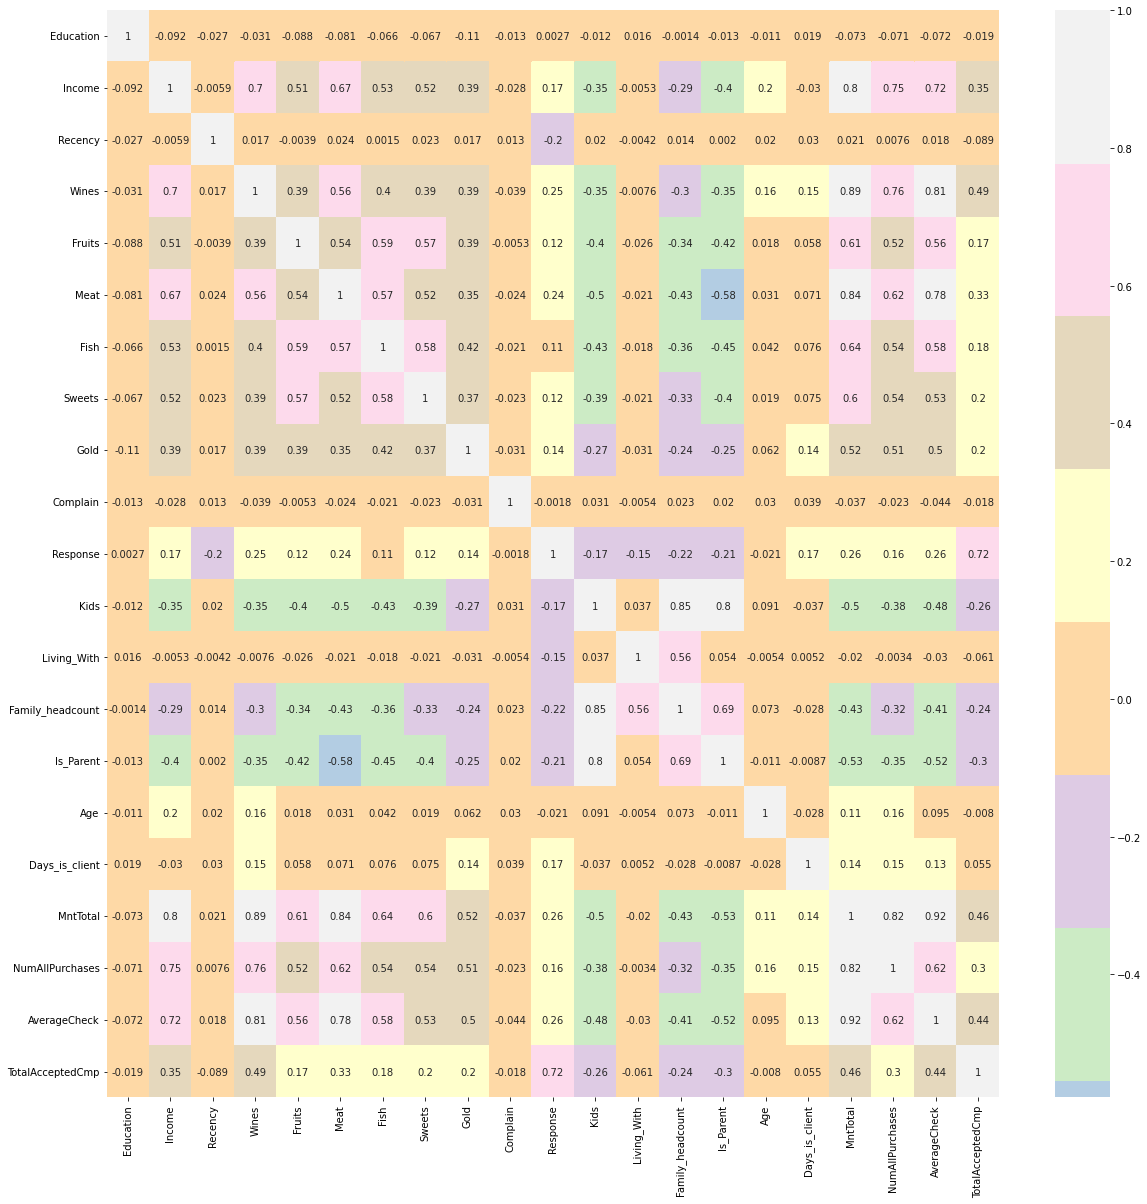

In [35]:
#Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib import colors
correlation_matrix= cpa_copy.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(correlation_matrix,annot=True, cmap='Pastel1', center=0) #generating the matrix

In [36]:

from matplotlib import pyplot as plot
from sklearn.decomposition import PCA
# initially get all the  components and then check for retention by plotting a scree plot.
pca = PCA() 

#transform 
cpa_pca_transformed = pca.fit_transform(cpa_copy)

#gconverting to dataframe
cpa_pca= pd.DataFrame(data =  cpa_pca_transformed)

# print the component data
cpa_pca

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,5.417759,1.229057,0.566618,0.972217,1.785220,-0.264575,-0.097638,0.564289,1.089636,1.456307,...,-0.455273,-0.285171,-0.609020,0.241640,0.814795,0.037156,-0.673844,-0.226338,1.072415e-16,-1.777778e-15
1,-2.844883,0.026546,-0.120855,1.919754,-1.506641,-1.308937,0.255321,0.172327,-0.110385,0.396073,...,-0.324825,-0.255365,0.206505,-0.063794,-0.293428,0.170304,-0.117837,-0.262320,-7.598078e-15,8.647445e-15
2,1.870589,0.261845,-1.233935,-0.575328,-0.678545,-0.555644,0.631561,0.168706,1.437353,-0.399681,...,0.241877,0.376305,-1.329591,0.194527,-0.551761,0.090340,-0.551057,0.118021,-1.348973e-17,-8.533412e-16
3,-2.758799,0.519393,-0.524317,-1.121640,-1.002874,-1.696684,0.340560,-0.685151,-0.374264,-0.525299,...,0.107121,0.014167,-0.185694,-0.194388,0.650117,-0.036734,-0.030891,-0.038435,-1.553225e-15,-1.567213e-15
4,-0.699694,-0.615940,-1.109590,-0.691529,-0.091181,0.419275,-0.418805,-1.012731,-1.387117,0.355089,...,0.209889,0.525751,-0.480764,0.413205,0.036744,-0.492458,0.025323,0.225157,-4.141348e-15,8.972672e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,2.599844,-2.435821,-0.591035,0.062590,1.206748,-1.120289,-0.480845,0.650039,0.155186,0.038368,...,0.670293,-0.749624,1.672447,-0.976813,0.266767,-0.652450,-0.243515,-0.276646,5.965707e-17,2.089411e-16
2230,-2.030448,-3.281081,1.188619,0.794197,-2.561103,0.377934,0.291761,-0.314380,-0.756847,0.760026,...,-0.127338,-0.075377,-0.000816,0.044475,-0.566690,1.023795,-0.459570,0.313980,2.709223e-16,-2.740500e-17
2231,2.626179,1.748329,-0.732709,1.131319,-0.359896,0.144767,-0.741279,-2.056230,-0.474675,-1.330691,...,0.070715,0.878810,-0.347043,-0.831014,0.003706,0.560458,-0.591971,0.079162,-5.575706e-17,3.945968e-17
2232,0.767611,-1.573685,-0.225045,-0.209939,-1.449009,-0.123914,0.583175,1.493573,0.102574,-0.329903,...,0.176551,-0.087521,-0.645837,0.384818,0.363457,-0.212076,0.193781,0.094673,1.868876e-16,4.303154e-17


In [37]:
pca.explained_variance_ratio_

array([3.65510887e-01, 9.09579834e-02, 7.82737236e-02, 5.41640879e-02,
       5.24029660e-02, 4.95102088e-02, 4.76060833e-02, 4.54387067e-02,
       3.97416067e-02, 3.54485776e-02, 3.19945109e-02, 2.22668759e-02,
       1.97378579e-02, 1.82061804e-02, 1.64265698e-02, 1.15294679e-02,
       9.56744176e-03, 8.77029223e-03, 2.44597231e-03, 7.20890591e-33,
       4.57632829e-33])

In [38]:
pca = PCA(n_components=9) 

#transform 
cpa_pca_transformed = pca.fit_transform(cpa_copy)

#converting to dataframe
cpa_pca= pd.DataFrame(data =  cpa_pca_transformed)

# print the component data
cpa_pca

,0,1,2,3,4,5,6,7,8
0,5.417759,1.229057,0.566618,0.972217,1.785220,-0.264575,-0.097638,0.564289,1.089636
1,-2.844883,0.026546,-0.120855,1.919754,-1.506641,-1.308937,0.255321,0.172327,-0.110385
2,1.870589,0.261845,-1.233935,-0.575328,-0.678545,-0.555644,0.631561,0.168706,1.437353
3,-2.758799,0.519393,-0.524317,-1.121640,-1.002874,-1.696684,0.340560,-0.685151,-0.374264
4,-0.699694,-0.615940,-1.109590,-0.691529,-0.091181,0.419275,-0.418805,-1.012731,-1.387117
...,...,...,...,...,...,...,...,...,...
2229,2.599844,-2.435821,-0.591035,0.062590,1.206748,-1.120289,-0.480845,0.650039,0.155186
2230,-2.030448,-3.281081,1.188619,0.794197,-2.561103,0.377934,0.291761,-0.314380,-0.756847
2231,2.626179,1.748329,-0.732709,1.131319,-0.359896,0.144767,-0.741279,-2.056230,-0.474675
2232,0.767611,-1.573685,-0.225045,-0.209939,-1.449009,-0.123914,0.583175,1.493573,0.102574


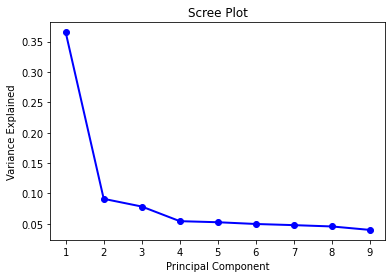

In [39]:
pca_values = np.arange(pca.n_components_) + 1
plot.plot(pca_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plot.title('Scree Plot')
plot.xlabel('Principal Component')
plot.ylabel('Variance Explained')
plot.show()


In [40]:
# from the above graph taking 3 components
pca = PCA(n_components=4) 

#transform 
cpa_pca_transformed = pca.fit_transform(cpa_copy)

#gconverting to dataframe
cpa_pca= pd.DataFrame(data =  cpa_pca_transformed, columns=(["col1","col2", "col3", "col4"]))

# print the component data
cpa_pca.head(5)

,col1,col2,col3,col4
0,5.417761,1.228800,0.566380,0.979729
1,-2.844884,0.026776,-0.120406,1.920965
2,1.870590,0.261689,-1.236250,-0.601605
3,-2.758798,0.519145,-0.524589,-1.126101
4,-0.699693,-0.616287,-1.110915,-0.706731


In [41]:
cpa_pca.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2234.0,-1.040648e-16,2.771131,-4.124883,-2.381722,-0.831088,2.077756,8.055926
col2,2234.0,1.009339e-16,1.382379,-4.743738,-0.993800,0.011609,0.855357,4.773495
col3,2234.0,1.129108e-16,1.282374,-3.183867,-0.724267,-0.185237,0.399128,5.094818
col4,2234.0,-6.087839e-18,1.066652,-3.114668,-0.750349,-0.107048,0.768413,5.547148


In [42]:
cpa_pca.to_csv("/content/cpa_clean.csv", index = False, header=True)

Using the elbow to determine the number of clusters.

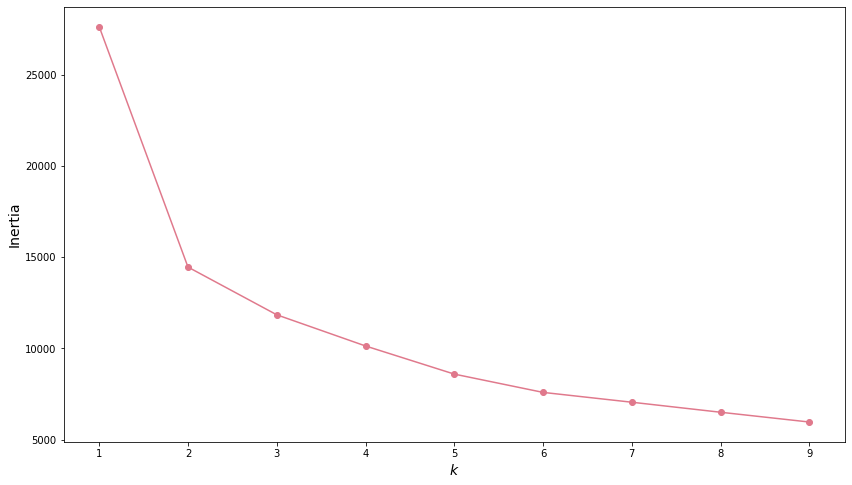

In [ ]:
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(cpa_pca)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.plot(range(1, 10), inertias, "bo-" ,color= colors[0])
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

plt.show()

Measuring the Silhouette score to calculate the goodness of a clustering technique.

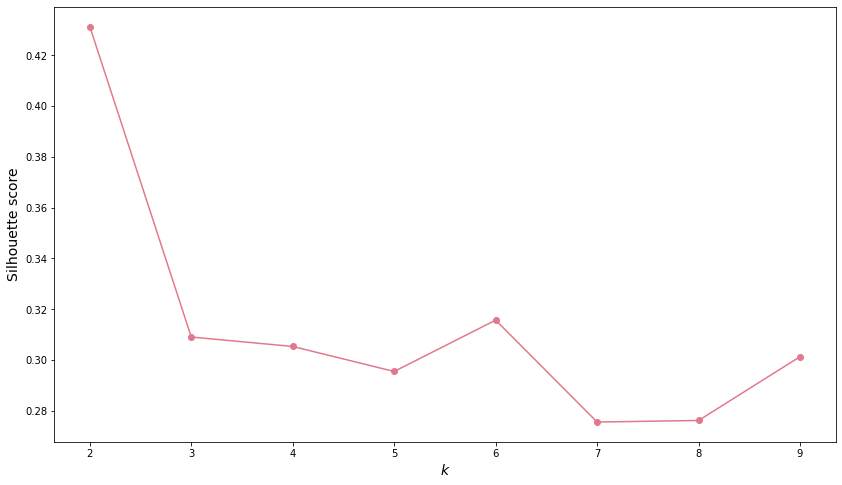

In [ ]:
plt.figure(figsize = (14,8) )
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(cpa_pca, model.labels_)
                     for model in kmeans_per_k[1:]]
plt.plot(range(2, 10), silhouette_scores, "bo-" ,color=colors[0])
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

We can see that the elbow was not sure of 2 or 3 , but the silhouetter score determines that k = 2.

In [ ]:
clusters = KMeans(n_clusters=2, random_state=42).fit(cpa_pca)
cpa["Personality"]= clusters.labels_

**What is the percentage of each cluster ?**

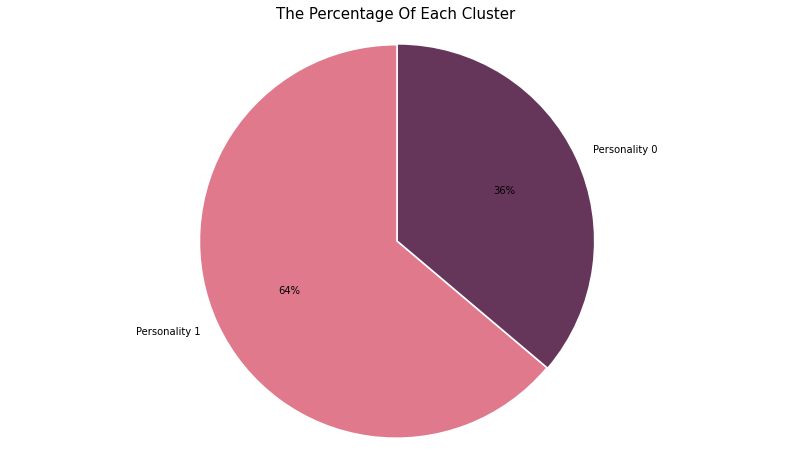

In [ ]:
plt.figure(figsize = (14,8) )
plt.pie(list(cpa['Personality'].value_counts()),labels=['Personality 1' , 'Personality 0'],
        autopct='%.00f%%' ,colors=colors, startangle=90  , explode =(0.01,0))
plt.title('The Percentage Of Each Cluster ' ,fontsize = 15)
plt.axis('equal')
plt.show()

**What is the Age Distribution of each cluster ?**

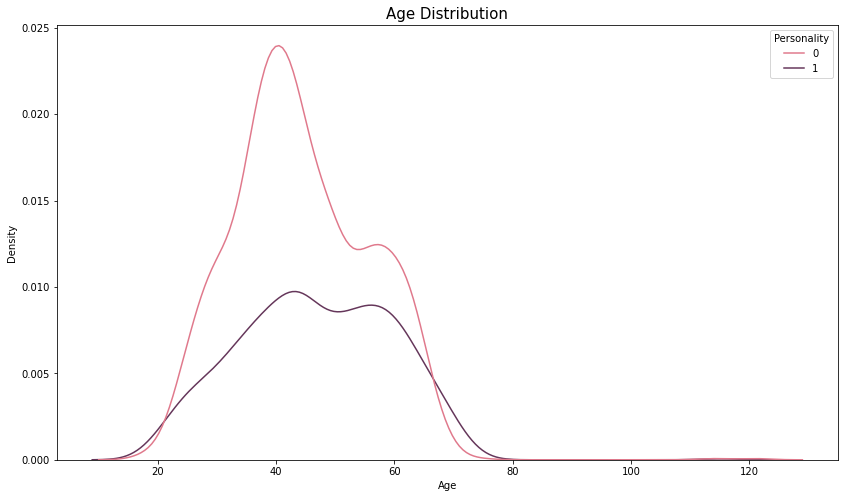

In [ ]:
plt.figure(figsize = (14,8) )
sns.kdeplot(data =cpa, x = 'Age' , hue = 'Personality' , palette=colors[:2])
plt.title('Age Distribution' ,fontsize = 15)
plt.show()

In [ ]:
clus0 = cpa[(cpa['Age'] > 40 )&(cpa['Personality'] == 0)]
clus1 = cpa[(cpa['Age'] > 40 )&(cpa['Personality'] == 1)]
print('percentage of customer more than 40 at cluster0 : {0:0.2f}%'.format(len(clus0) / len(cpa[cpa['Personality'] == 0] )))
print('percentage of customer more than 40 at cluster1 : {0:0.2f}%'.format(len(clus1) / len(cpa[cpa['Personality'] == 1])))

percentage of customer more than 40 at cluster0 : 0.60%
percentage of customer more than 40 at cluster1 : 0.67%


In [ ]:
len(cpa['Personality'] == 0)

2234

**What is the income Distribution of each cluster ?**

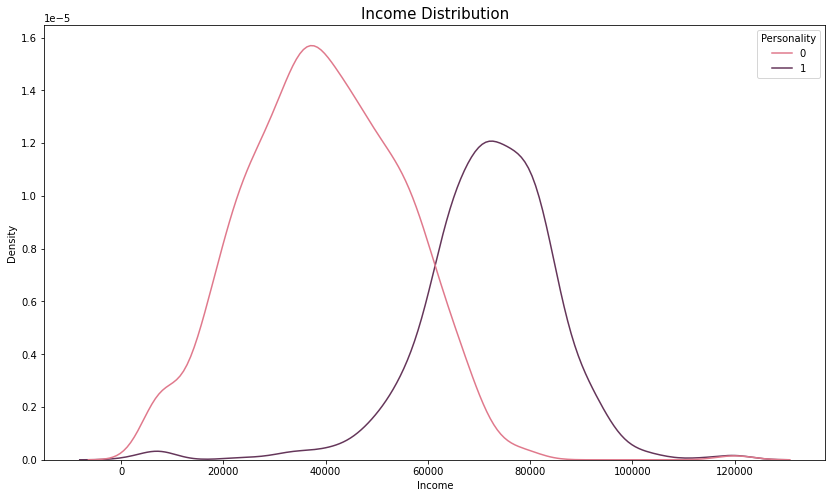

In [ ]:
plt.figure(figsize = (14,8) )
sns.kdeplot(data =cpa, x = 'Income' , hue = 'Personality' ,palette=colors[:2])
plt.title('Income Distribution' ,fontsize = 15)
plt.show()

Insight

cluster 1 gain more money with mean of 62,760$

cluster 0 gain more money with mean of 35,615$

In [ ]:
cpa.groupby(['Personality'])['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Personality,,,,,,,,
0,1426.0,39832.331697,15392.348263,4428.0,28765.25,39168.0,50773.00,120000.0
1,808.0,71896.103960,13380.012918,2447.0,64883.25,72303.5,80217.25,120000.0


In [48]:
cpa_quantum = pd.read_csv("/content/cpa_clean.csv")
cpa_quantum

,col1,col2,col3,col4
0,5.417761,1.228800,0.566380,0.979729
1,-2.844884,0.026776,-0.120406,1.920965
2,1.870590,0.261689,-1.236250,-0.601605
3,-2.758798,0.519145,-0.524589,-1.126101
4,-0.699693,-0.616287,-1.110915,-0.706731
...,...,...,...,...
2229,2.599841,-2.435121,-0.587616,0.106180
2230,-2.030449,-3.280843,1.188612,0.783368
2231,2.626182,1.747877,-0.735795,1.098662
2232,0.767612,-1.573897,-0.225342,-0.218788


In [107]:
k=3

n= cpa_quantum.shape[0]
n
c=cpa_quantum.shape[1]
c

4

In [108]:
import numpy as np

 
centroid_min = cpa_quantum.min().min()
centroid_max = cpa_quantum.max().max()
centroids = []

for centroid in range(k):
   centroid = np.random.uniform(centroid_min, centroid_max, c)
  
   centroids.append(centroid.tolist())
 

centroids = pd.DataFrame(centroids, columns = cpa_quantum.columns)

centroids



,col1,col2,col3,col4
0,-3.979836,-0.992089,-0.896687,-2.954022
1,-1.791967,6.362025,-2.469816,-4.361754
2,1.191128,7.841753,6.270077,4.726851


In [3]:
#install the qiskit
!pip install qiskit
# import math lib
from math import pi

# import Qiskit
from qiskit import Aer, IBMQ, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

     |████████████████████████████████| 6.5 MB 7.2 MB/s 
     |████████████████████████████████| 18.0 MB 1.3 MB/s 
     |████████████████████████████████| 240 kB 70.7 MB/s 
     |████████████████████████████████| 200 kB 60.0 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 112 kB 55.5 MB/s 
     |████████████████████████████████| 1.6 MB 38.0 MB/s 
     |████████████████████████████████| 49 kB 6.7 MB/s 
     |████████████████████████████████| 943 kB 61.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 37.5 MB 49.6 MB/s 
     |████████████████████████████████| 4.0 MB 55.5 MB/s 
     |████████████████████████████████| 112 kB 76.1 MB/s 
  Created wheel for qiskit: filename=qiskit-0.36.1-py3-none-any.whl size=11887 sha256=b4210ed10d1d5ec50ba382295ccc9fd4f1598652fa721111308bf9deae1531ac
  Stored in directory: /root/.cache/pip/whe

In [4]:
simulator=Aer.get_backend('qasm_simulator')

In [117]:
qregister=QuantumRegister(5,'qregister')

# this holds the resultant measurements
cregister=ClassicalRegister(1,'cregister')


qc=QuantumCircuit(qregister,cregister,name='qc')

result_list=[]



In [118]:

def centroid_distances(point, centroids):
  for i in range(1,4):
    qc.h(qregister[4])

    #encoding the centroid and new points
   
    theta1= [ {((x + 1) * pi / 2) for x in [point[0], centroids[0][0],centroids[1][0], centroids[2][0]]}]
    theta2= [ {((x + 1) * pi / 2) for x in [point[1], centroids[0][1],centroids[1][1], centroids[2][1]]}]
    theta3= [ {((x + 1) * pi / 2) for x in [point[2], centroids[0][2],centroids[1][2], centroids[2][2]]}]
    theta4= [ {((x + 1) * pi / 2) for x in [point[3], centroids[0][3],centroids[1][3], centroids[2][3]]}]
    

    
    qc.h(qregister[2])

    qc.u3(theta4[0],theta3[0],theta2[0],theta1[0], 0,qregister[0])
    qc.u3(theta4[i],theta3[i],theta2[i],theta1[i],0,qregister[i])

    qc.cswap(qregister[3],qregister[4],qregister[2], qregister[0],qregister[1])


    qc.measure(qregister[2],cregister[0])

    qc.reset(qregister)

    execute_job=execute(qc, backend=simulator, shots=5000)
    result= execute_job.result().get_counts(qc)

    try:
      result_list.append(result['1'])
    except:
      result_list.append(0)












In [119]:
result_list

[]